In [1]:
import pandas as pd
import boto3
# import S3FS
import os.path
from pathlib import Path
from pyspark.sql import SparkSession
from boto3.session import Session
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.pyplot import figure
from helper_func import *
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot


In [2]:
data = pd.read_csv("emscad_v1.csv")

In [477]:
data.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'text'],
      dtype='object')

In [3]:
data.drop("in_balanced_dataset", inplace = True, axis = 1)

In [4]:
data["fraudulent"] = data["fraudulent"].replace(["f" , "t"], ["Not Fraud", "Fraud"])

In [5]:
fraud_prop = data.groupby("fraudulent").size().reset_index(name = "counts")
x = np.array(fraud_prop.iloc[:,0])
y = np.array(fraud_prop.iloc[:,1])
total = y.sum()

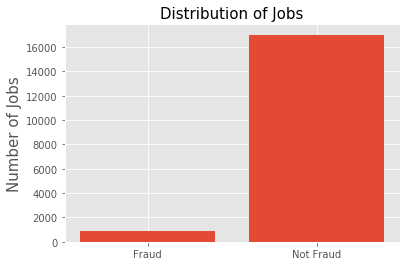

In [6]:
fig = plt.figure()
plt.bar(x, y) 
plt.ylabel("Number of Jobs", fontsize=15) 
plt.title("Distribution of Jobs", fontsize=15)
fig.savefig('images/fraud.png', bbox_inches='tight');

<Figure size 432x288 with 0 Axes>

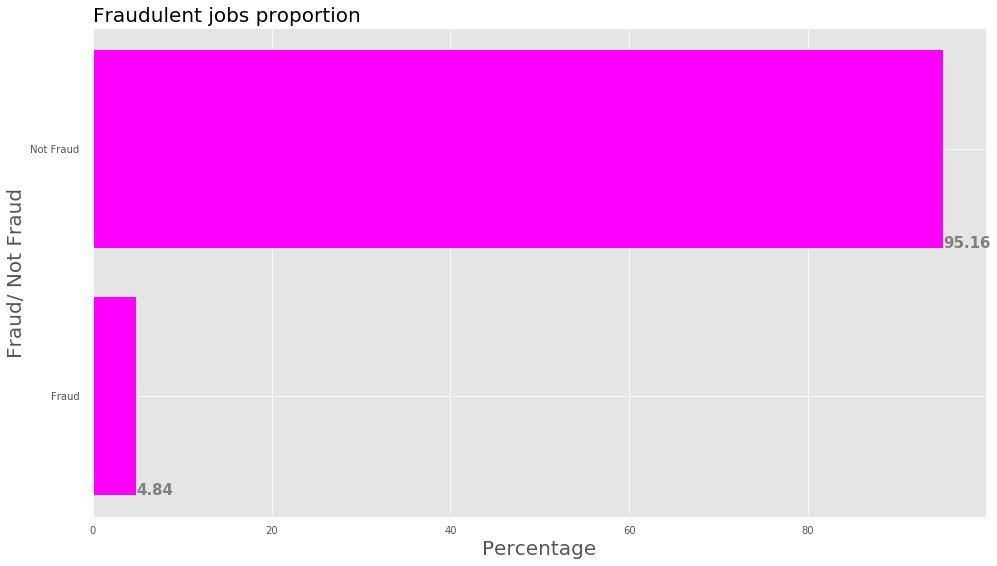

In [7]:
# fraud distribution percentages
fig = plt.figure()
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y*100/total, color="magenta")
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10)
for i in ax.patches: 
    plt.text(i.get_width(), i.get_y(),  
             str(round((i.get_width()), 2)), 
             fontsize = 15, fontweight ='bold', 
             color ='grey')
    
ax.set_title("Fraudulent jobs proportion", 
             loc ='left', fontsize =20) 
ax.set_ylabel("Fraud/ Not Fraud", fontsize =20)
ax.set_xlabel("Percentage", fontsize =20)
fig.savefig('images/fraud_perc.png', bbox_inches='tight')

In [8]:
data["fraudulent"] = data["fraudulent"].replace(["Not Fraud", "Fraud"], [0,1])

binary_cols = ["telecommuting", "has_company_logo","has_questions"]

for col in binary_cols:
    binarize(data,col)



In [9]:
fill_nulls(data)

<Figure size 432x288 with 0 Axes>

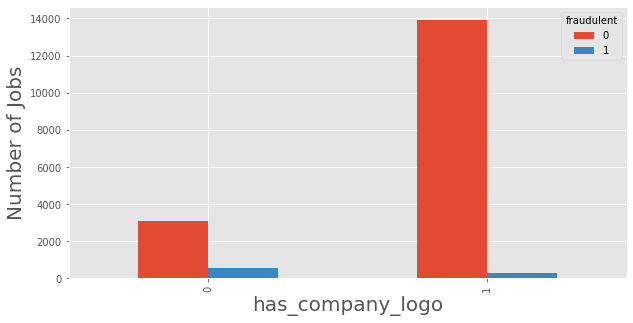

<Figure size 432x288 with 0 Axes>

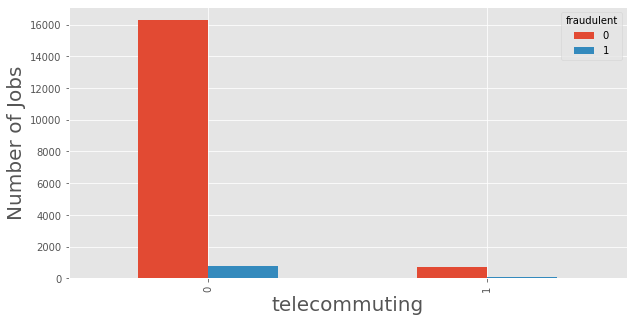

<Figure size 432x288 with 0 Axes>

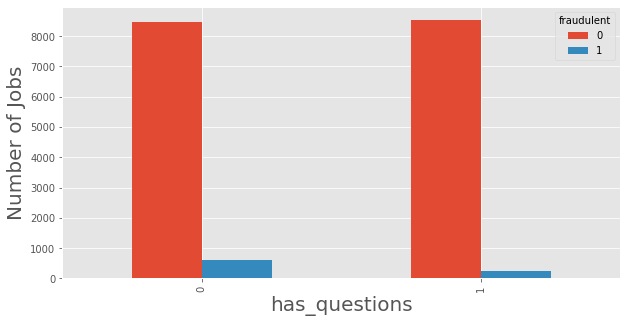

<Figure size 432x288 with 0 Axes>

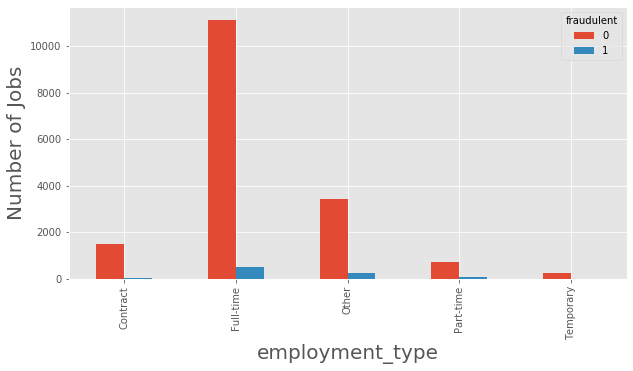

In [10]:
cols = ["has_company_logo","telecommuting", "has_questions", "employment_type" ]

for col in cols:
    plot_bar(data,col)

In [11]:
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

for col in text_cols:
    clean_cols(data,col)


<Figure size 432x288 with 0 Axes>

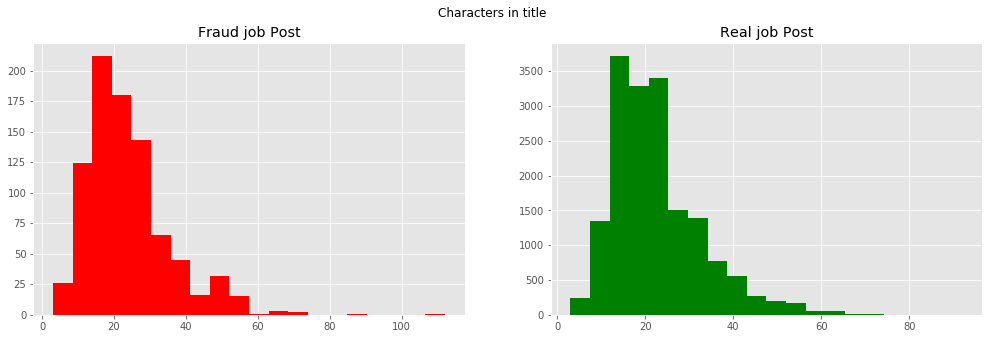

<Figure size 432x288 with 0 Axes>

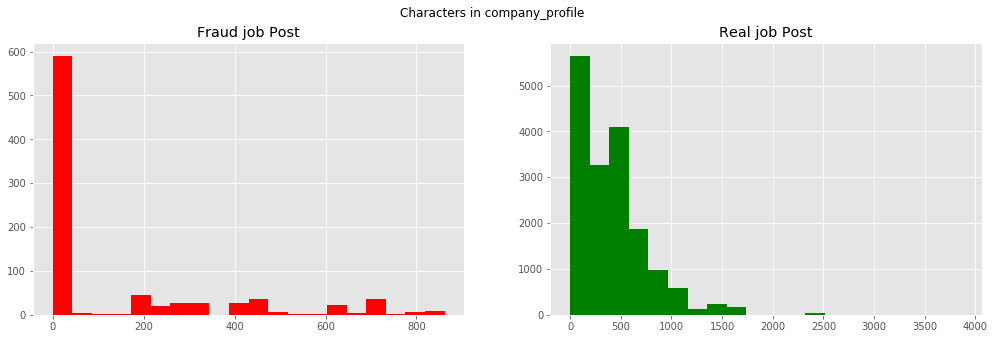

<Figure size 432x288 with 0 Axes>

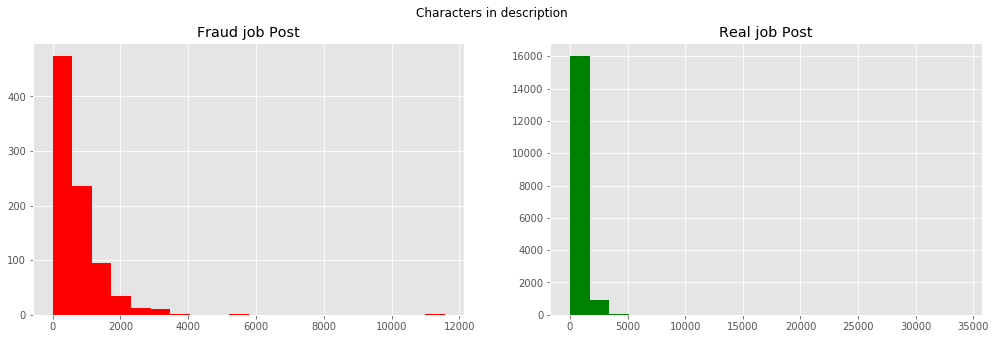

<Figure size 432x288 with 0 Axes>

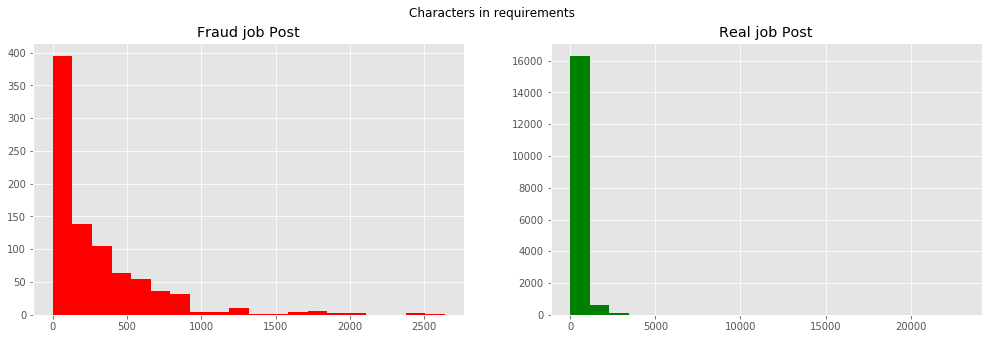

<Figure size 432x288 with 0 Axes>

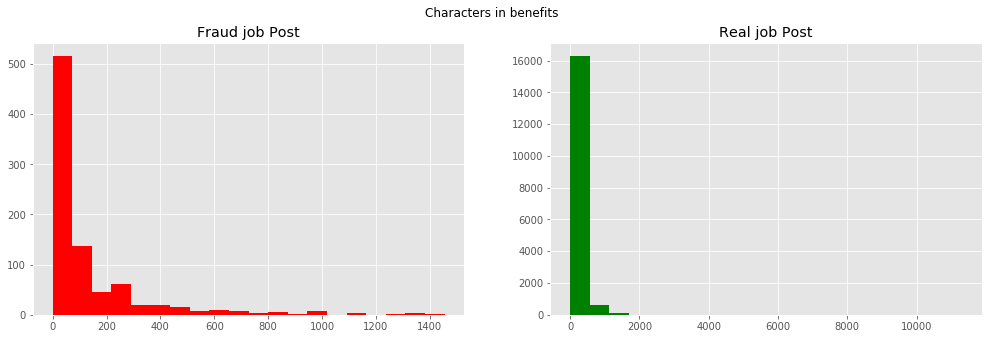

In [12]:
for col in text_cols:
    plot_text(data, col)

<Figure size 432x288 with 0 Axes>

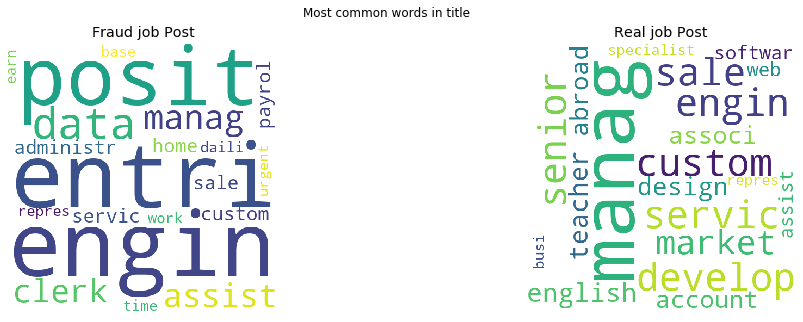

<Figure size 432x288 with 0 Axes>

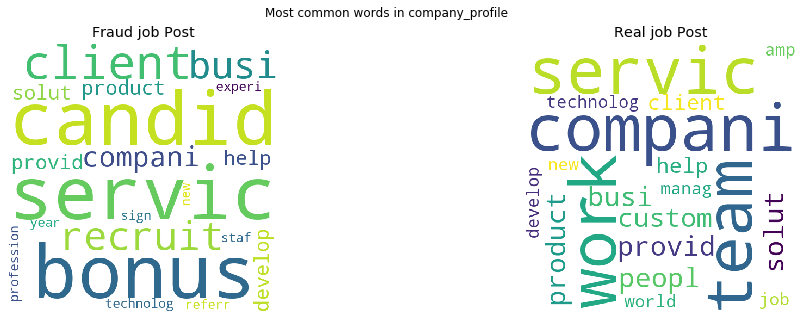

<Figure size 432x288 with 0 Axes>

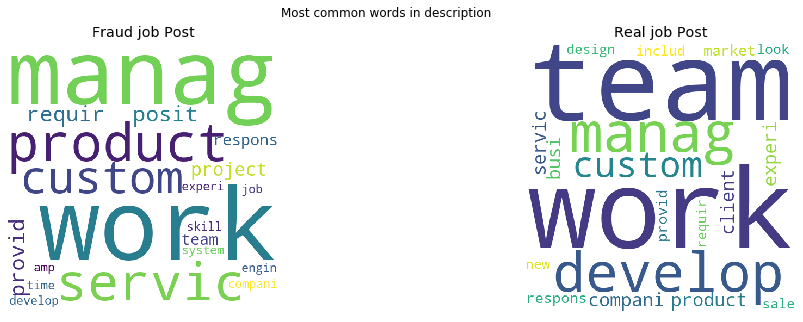

<Figure size 432x288 with 0 Axes>

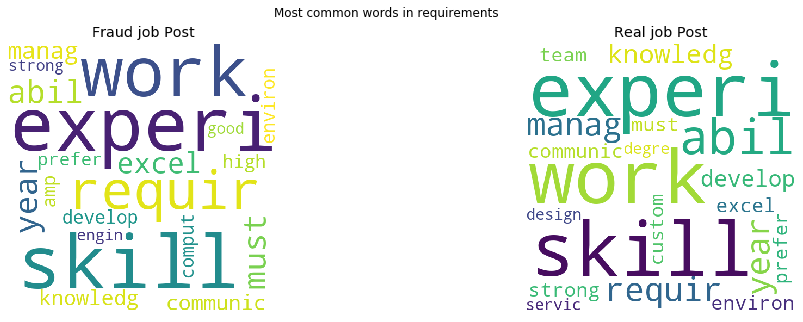

<Figure size 432x288 with 0 Axes>

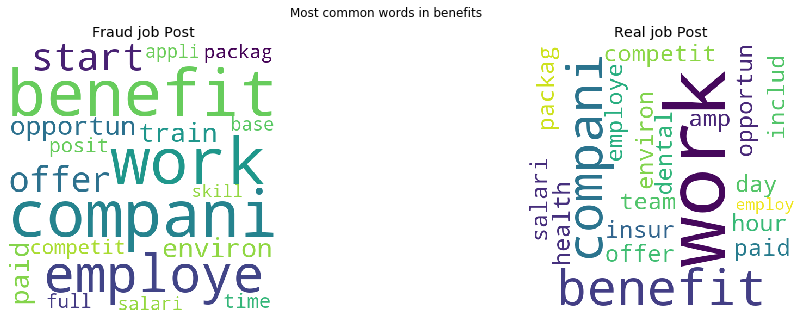

In [13]:
for col in text_cols:
    plot_wordcloud(data, col)

In [14]:
data["text"] = data["title"] + data["company_profile"] + data["description"] + data["requirements"] + data["benefits"]

In [15]:
data.to_pickle("data_text")

## Features Cleaning

In [16]:
df = data.copy()

In [17]:
clean_features(df)


## BASELINE MODEL

In [18]:
# Accuracy is useless in problems with unequal classes and has absolutely no predictive power

In [19]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [20]:
y_actual = np.array(df["fraudulent"])

In [21]:
y_pred0 = np.zeros(len(y_actual))
y_pred1 = np.ones(len(y_actual))
pred_y = np.random.choice([0,1],size=(len(y_actual),), p=[0.95,0.05])

In [22]:
cf = confusion_matrix(y_pred0, y_actual)


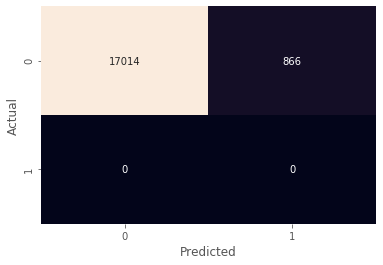

In [23]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cf, annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

### Baseline Results

In [24]:
#no frauds
generate_model_report(y_actual, y_pred0)

Accuracy: 0.952
Precision: 0.000
Recall: 0.000
F1 score: 0.000


/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
#all frauds
generate_model_report(y_actual, y_pred1)

Accuracy: 0.048
Precision: 0.048
Recall: 1.000
F1 score: 0.092


In [26]:
# random prediction
generate_model_report(y_actual,pred_y)

Accuracy: 0.907
Precision: 0.049
Recall: 0.050
F1 score: 0.049


In [27]:
# All categories value except 'department', 'function'

fit_df = df[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'text', 'fraudulent']]


In [28]:
cat_df = fit_df[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'fraudulent']]

fit_df_dummy = pd.get_dummies(cat_df)



In [29]:
text_cat_df = pd.concat([fit_df_dummy, fit_df["text"]], axis = 1)


In [30]:
text_cat_df.to_pickle("cleaned_textCol.pkl")

## To balance or not to balance

0    17014
1      866
Name: fraudulent, dtype: int64


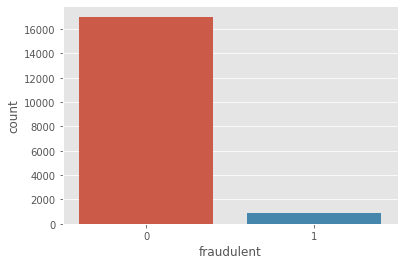

In [31]:
## Split first to avoid leakage and to handle imbalance


X = text_cat_df.drop("fraudulent", axis=1)
y = text_cat_df["fraudulent"]

X_cat, y_cat = fit_df_dummy.drop("fraudulent", axis=1), fit_df_dummy["fraudulent"]

# splitting text and categorical columns
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = .20, random_state=1)

#splitting only categorical columns
X_cat_train, X_cat_test, y_cat_train,y_cat_test = train_test_split(X_cat, y_cat, stratify=y , test_size = .20, random_state=1)


ax = sns.countplot(x = y, data = X)
print(y.value_counts())

# before balancing the data


## SMOTE

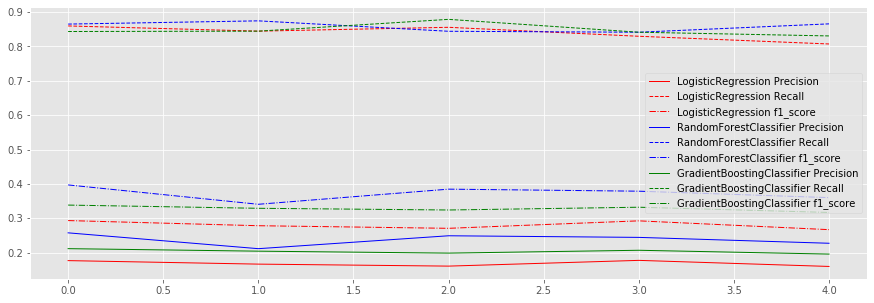

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators, X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='undersampling' )
ax.legend()

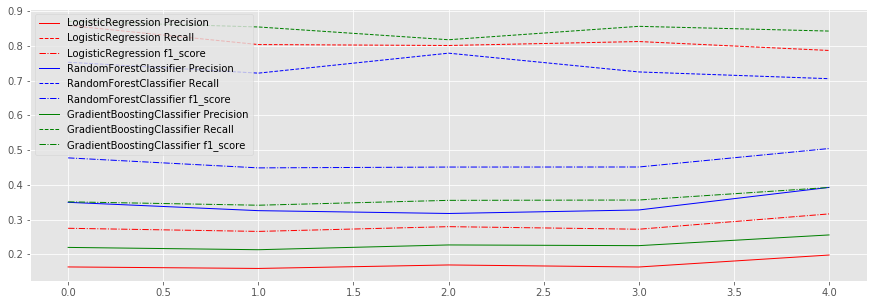

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='oversampling' )
ax.legend()

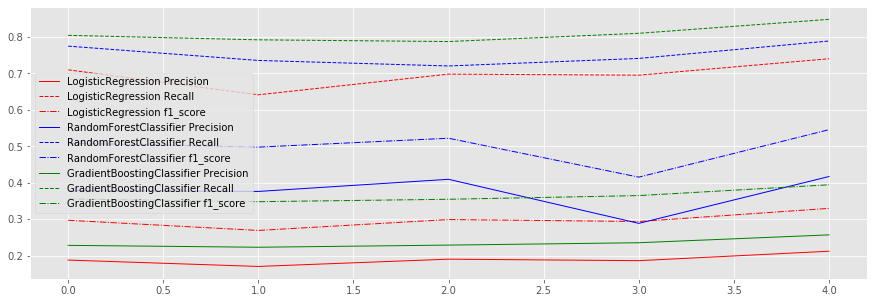

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='smote' )
ax.legend()

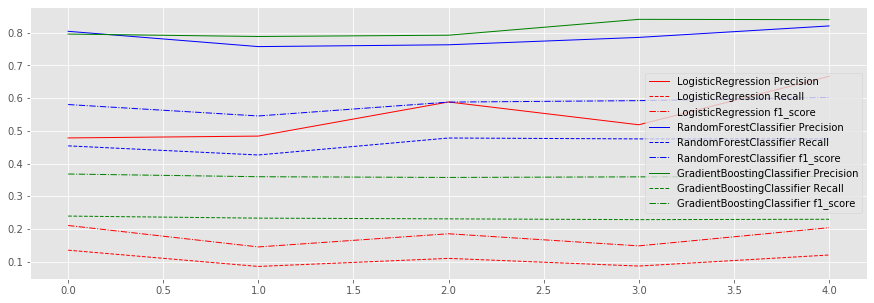

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='None' )
ax.legend()

## Model only with categorical features

RandomForestClassifier F1 Score:  0.607
RandomForestClassifier PR AUC: 0.690
Accuracy: 0.969
Precision: 0.794
Recall: 0.491
F1 score: 0.607


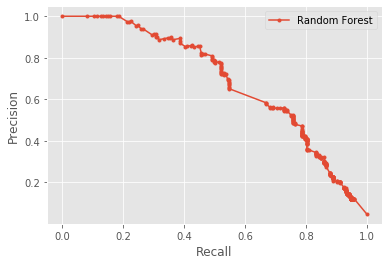

In [36]:
model = RandomForestClassifier()
model.fit(X_cat_train, y_cat_train)

yhat = model.predict_proba(X_cat_test)
pos_probs = yhat[:, 1]


y_pred = model.predict(X_cat_test)


# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_cat_test, pos_probs)
F1_Score = f1_score(y_cat_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Random Forest')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)

generate_model_report(y_cat_test, y_pred)
cm = confusion_matrix(y_cat_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

<Figure size 432x288 with 0 Axes>

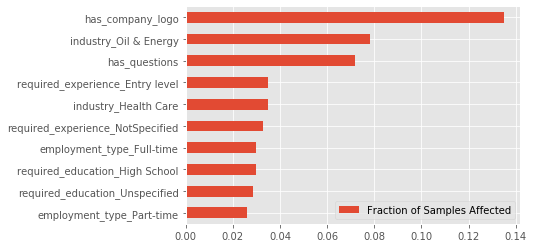

In [37]:
# Plot the feature importance
fig = plt.figure()
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=X_cat_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False)
y = feat_scores[:10]
y[::-1].plot(kind='barh')
fig.savefig(f"images/cat_feature_imp", bbox_inches='tight');

## TFIDF vectorization

In [38]:
tfidf = TfidfVectorizer(max_features = 2000)

In [39]:
tfidf_matrix_train = tfidf.fit_transform(X_train.text.values.astype('U'))

In [40]:
tfidf_matrix_test =  tfidf.transform(X_test.text.values.astype('U'))

In [41]:
nlp_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf.get_feature_names())
nlp_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=tfidf.get_feature_names())

In [42]:
nlp_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
cat_nlp_train = pd.concat([nlp_train, X_train], axis=1)

nlp_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
cat_nlp_test = pd.concat([nlp_test, X_test], axis=1)

In [43]:
cat_nlp_train = cat_nlp_train.drop("text", axis=1)
cat_nlp_test = cat_nlp_test.drop("text", axis=1);

No Skill F1 Score: 0.045
No Skill PR AUC: 0.063
Accuracy: 0.905
Precision: 0.044
Recall: 0.046
F1 score: 0.045


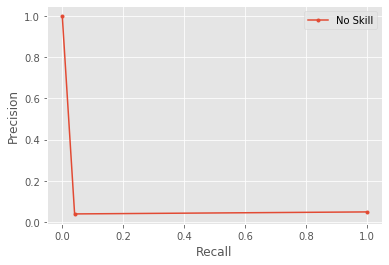

In [44]:
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot


# setting up a dummy model
model = DummyClassifier(strategy='stratified')  #Predict 0 or 1 proportional to the prior probability in the dataset 
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
y_pred = model.predict(cat_nlp_test)
pos_probs = yhat[:, 1]



# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='No Skill')
print('No Skill F1 Score: %.3f' % F1_Score)
print('No Skill PR AUC: %.3f' % auc_score)

generate_model_report(y_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.250000, F-Score=0.834
Best Threshold=0.250000, Precision=0.855, Recall=0.815




RandomForestClassifier F1 Score:  0.746
RandomForestClassifier PR AUC: 0.900
Accuracy: 0.980
Precision: 1.000
Recall: 0.595
F1 score: 0.746


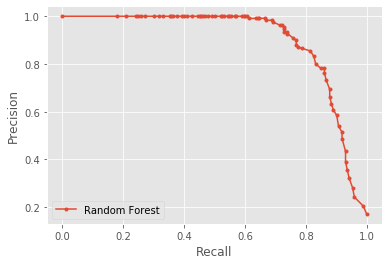

In [45]:
model = RandomForestClassifier()
model.fit(cat_nlp_train, y_train)

yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]


y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_test, pos_probs)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f'  % (thresholds[ix], precision[ix], recall[ix]))
print("\n\n\n")
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Random Forest')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)

generate_model_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Plot the feature importance


fig = plt.figure()
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=cat_nlp_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending = False)[:10]
y = feat_scores[:10]
y[::-1].plot(kind="barh")
fig.savefig(f"images/text_feature_imp", bbox_inches='tight');

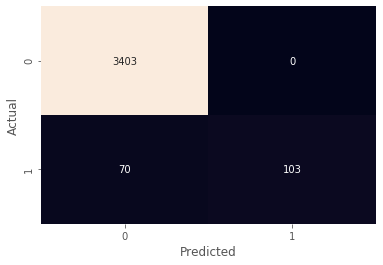

In [46]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cm , annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

GradientBoostingClassifier F1 Score:  0.676
GradientBoostingClassifier PR AUC: 0.770
Accuracy: 0.975
Precision: 0.880
Recall: 0.549
F1 score: 0.676


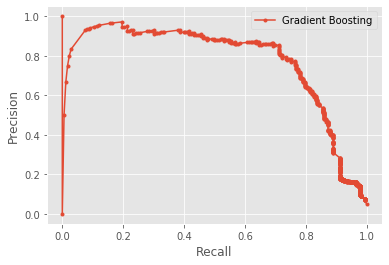

In [47]:
model = GradientBoostingClassifier()
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]
y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Gradient Boosting')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)
generate_model_report(y_test, y_pred)



# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

LogisticRegression F1 Score:  0.664
LogisticRegression PR AUC: 0.789
Accuracy: 0.974
Precision: 0.901
Recall: 0.526
F1 score: 0.664


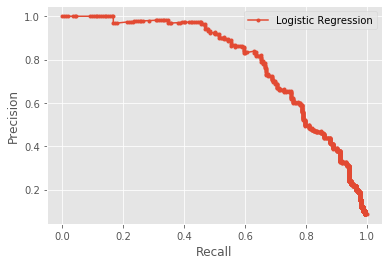

In [48]:
model = LogisticRegression(max_iter=500)
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]
y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Logistic Regression')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)
generate_model_report(y_test, y_pred)


# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# LSTM

In [292]:
lstm_df = pd.read_pickle("cleaned_textCol.pkl")

In [293]:
lstm_df = lstm_df[["text", "fraudulent"]]

In [294]:
lstm_df.fraudulent = lstm_df.fraudulent.replace([0,1],["Not fraud","fraud"])

In [295]:
from nltk.corpus import stopwords
lstm_df = lstm_df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
lstm_df.text = lstm_df.text.apply(clean_text)
lstm_df.text = lstm_df.text.str.replace('\d+', '')

In [296]:
X = lstm_df.text
y = lstm_df.fraudulent

In [297]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [298]:
y = le.fit_transform(y)
y.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [299]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.15)

In [300]:
import tensorflow as tf
keras = tf.keras

# The maximum number of words to be used. (most frequent)
max_words = 50000
# Max number of words in each complaint.
max_length = 250
# This is fixed.
embedding_dim = 100


tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 61124 unique tokens.


In [301]:
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)
print('Shape of data tensor:', sequences_matrix.shape)

Shape of data tensor: (15198, 250)


In [302]:
from keras.layers import Embedding, LSTM, Dense, Input, Activation, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
# def RNN():
#     inputs = Input(name="inputs", shape=[max_length])
#     layer = Embedding(max_words,100,input_length=max_length)(inputs)
#     layer = LSTM(64)(layer)
#     layer = Dense(256, name="FC1")(layer)
#     layer = Activation("relu")(layer)
#     layer = Dropout(0.2)(layer)
#     layer = Dense(1,name="out_layer")(layer)
#     layer = Activation("sigmoid")(layer)
#     model = Model(inputs=inputs,outputs=layer)
#     return model

In [448]:
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_length))
model.add(LSTM(64))

model.add(Dense(16, name="FC1"))
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(8, activation=tf.nn.relu))
model.add(Dropout(0.4))

model.add(Dense(1,name="out_layer"))
model.add(Activation("sigmoid"))

In [449]:
import keras.backend as K

def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

In [450]:
# model = RNN()
model.summary()
model.compile(loss="binary_crossentropy", optimizer=RMSprop(), metrics=["accuracy", precision, recall, f1_score])

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
lstm_46 (LSTM)               (None, 64)                42240     
_________________________________________________________________
FC1 (Dense)                  (None, 16)                1040      
_________________________________________________________________
activation_87 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_45 (Dropout)         (None, 8)               

In [473]:
model.fit(sequences_matrix, Y_train, batch_size=200, epochs=6, validation_split=.20, 
          callbacks=[EarlyStopping(monitor="val_loss", min_delta=0.0001)])

Epoch 1/6
61/61 [==============================] - 32s 527ms/step - loss: 0.0204 - accuracy: 0.9945 - precision: 0.9892 - recall: 0.8935 - f1_score: 0.9359 - val_loss: 0.2695 - val_accuracy: 0.9760 - val_precision: 0.8357 - val_recall: 0.6411 - val_f1_score: 0.7186
Epoch 2/6
61/61 [==============================] - 52s 858ms/step - loss: 0.0210 - accuracy: 0.9951 - precision: 0.9914 - recall: 0.9075 - f1_score: 0.9429 - val_loss: 0.2353 - val_accuracy: 0.9773 - val_precision: 0.8185 - val_recall: 0.6817 - val_f1_score: 0.7326
Epoch 3/6
61/61 [==============================] - 38s 616ms/step - loss: 0.0187 - accuracy: 0.9955 - precision: 0.9926 - recall: 0.9185 - f1_score: 0.9507 - val_loss: 0.2140 - val_accuracy: 0.9401 - val_precision: 0.4348 - val_recall: 0.7357 - val_f1_score: 0.5385
Epoch 4/6
61/61 [==============================] - 36s 587ms/step - loss: 0.0151 - accuracy: 0.9964 - precision: 0.9947 - recall: 0.9367 - f1_score: 0.9630 - val_loss: 0.4597 - val_accuracy: 0.9523 - va

In [474]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequence_matrix = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length)

In [475]:
accr = model.evaluate(test_sequence_matrix, Y_test)

84/84 [==============================] - 3s 39ms/step - loss: 0.4017 - accuracy: 0.9609 - precision: 0.5079 - recall: 0.6171 - f1_score: 0.5292


In [476]:
print(f"Test set\n Loss:{accr[0]}\n Accuracy: {accr[1]}\n Precision: {accr[2]}\n Recall: {accr[3]}\n F1 Score: {accr[4]}")

Test set
 Loss:0.4017360508441925
 Accuracy: 0.9608501195907593
 Precision: 0.5079365372657776
 Recall: 0.6170635223388672
 F1 Score: 0.5292233228683472


In [467]:
test_case = ["software team team company experience work health software development"]
txts=tokenizer.texts_to_sequences(test_case)
txts = tf.keras.preprocessing.sequence.pad_sequences(txts,maxlen=max_length)

In [468]:
pred = model.predict(txts)
print(pred)

[[0.9230233]
 [0.9230233]]
